### Importamos librerias necesarias.

In [1]:
from sklearn import tree, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Funciones:
* Crear gráficos para analizar el peso en churn de cada variable.
* Pasar a porcentajes la matriz de confusión.

In [2]:
color = plt.get_cmap('RdYlGn')(np.linspace(start = 0.15
                                           , stop = 0.85
                                           , num = 1))

def contingencia(df, discreta, etiq = False):

    df_temp = df.groupby([discreta])['Churn']
    df_temp = df_temp.sum() / df_temp.count()
    
    Grafico = df_temp.plot(kind = 'barh'
                       , width = 0.5
                       , color = color
                       , stacked = True
                       , legend = False
                       , fontsize = 10)
    
    [spine.set_visible(False) for spine in Grafico.spines.values()]
    Grafico.spines['left'].set_visible(True)
    Grafico.set_xlim([0,0.5])
    
    if etiq == True:
        vals = Grafico.get_xticks()
        Grafico.set_xticklabels(['{:3.0f} %'.format(x * 100) for x in vals])
    else:
        Grafico.set_xticklabels('')

    plt.tick_params(left = False, bottom = False)
    Grafico.set_ylabel('')
    Grafico.grid(axis='x',alpha=0.25)

    plt.title(discreta)
    
def matriz(test, pred):
    mc = confusion_matrix(Y_test, Y_Pred)
    Total = sum(sum(mc))
    mc = np.round(mc / Total * 100,2)
    
    return mc

### Cargamos datos y eliminamos valores faltantes de en _TotalCharges_.
* Creamos Churn_b con valores binarios.
* Mezclamos el DataFrame para hacer los análisis.

In [3]:
le = preprocessing.LabelEncoder() 

df = pd.read_csv('data.csv')

df['TotalCharges'].replace(' ', np.nan, inplace=True)
df = df.dropna(subset = ['TotalCharges'])
df = df.sample(frac = 1
               , random_state = 12345)
   
df['Churn'] =  df[['Churn']].apply(le.fit_transform)

df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3281,6322-PJJDJ,Male,0,Yes,No,49,Yes,No,Fiber optic,No,...,No,No,Yes,Yes,Two year,Yes,Electronic check,94.80,4690.65,0
1625,1262-OPMFY,Female,0,Yes,No,9,Yes,No,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Bank transfer (automatic),75.75,655.9,1
4606,1734-ZMNTZ,Female,0,Yes,Yes,11,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.00,300.7,0


In [4]:
df_Churn = df.groupby(by = ['Churn'])['customerID'].count().reset_index()
df_Churn['Ratio'] = df_Churn.customerID / df_Churn.customerID.sum()
df_Churn

,Churn,customerID,Ratio
0,0,5163,0.734215
1,1,1869,0.265785


* <b>Creamos lista de columnas y eliminamos las que contienen datos numéricos.</b>

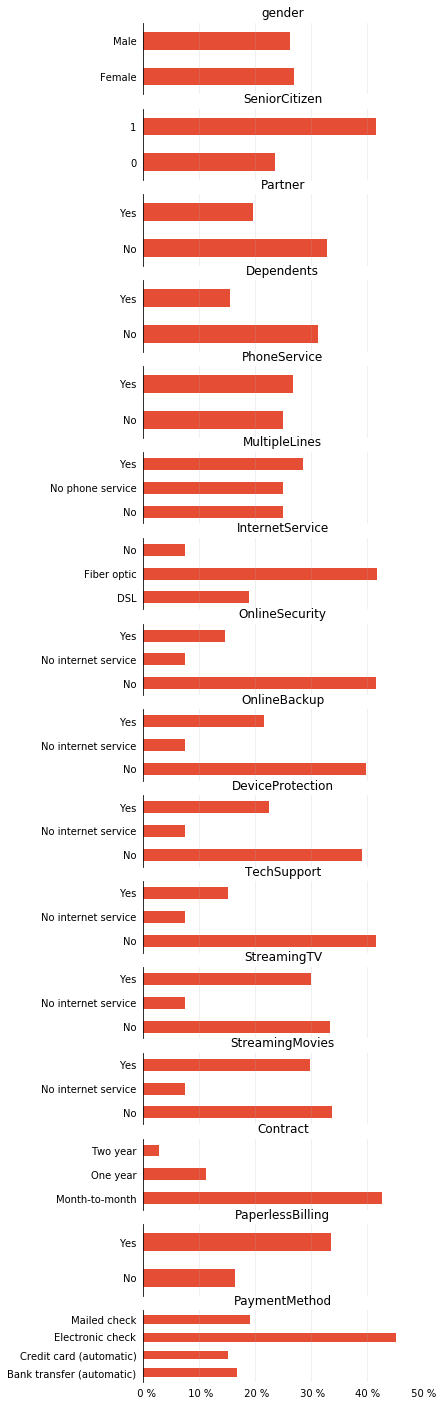

In [5]:
columnsList = df.columns.tolist()
plt.rcParams['figure.figsize'] = (5, 25)

excluir = ['customerID','TotalCharges','tenure','MonthlyCharges','Churn','Churn_b']

for i in excluir:
    if i in columnsList:
        columnsList.remove(i)

for i in range(1,len(columnsList) + 1):
    plt.subplot(len(columnsList), 1, i)
    if i == len(columnsList):
        contingencia(df, columnsList[i -1], etiq = True)
    else:
        contingencia(df, columnsList[i -1])

plt.show()
plt.close()

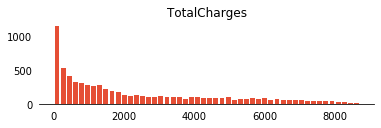

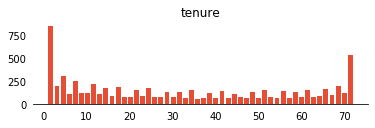

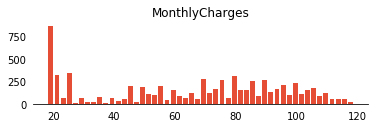

In [6]:
Var_Continuas = ['TotalCharges','tenure','MonthlyCharges']

for i in Var_Continuas:
    df[[i]].apply(pd.to_numeric).hist(bins = 50
                                      , grid = False
                                      , color = color
                                      , zorder = 2
                                      , figsize = (6, 1.5)
                                      , rwidth = 0.8)
    
    [spine.set_visible(False) for spine in plt.gca().spines.values()]
    plt.gca().spines['bottom'].set_visible(True)
    plt.tick_params(left = False, bottom = False)
    
    plt.show

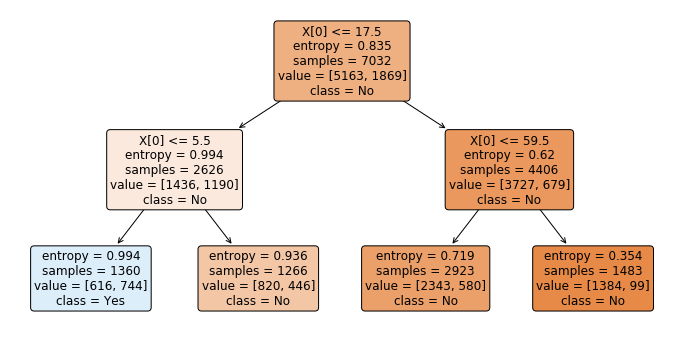

0.750592697961119

In [7]:
X = df[['tenure']]
Y = df['Churn'] 

plt.rcParams['figure.figsize'] = (12, 6)

X_train, X_test, Y_train, Y_test = train_test_split(X
                                                    , Y
                                                    , test_size = 0.7
                                                    , random_state = 12345)

lr = tree.DecisionTreeClassifier(criterion = 'entropy'
                                 , min_samples_split = 2000
                                 , max_depth = 2 )

lr = lr.fit(X, Y)

Grafico = tree.plot_tree(lr
                         , fontsize = 12
                         , max_depth = 7
                         , impurity = True
                         , rounded = True
                         , filled= True
                         , class_names = ['No', 'Yes']
                        )


plt.savefig('tree.png')

plt.show()
plt.close()

lr.score(X_train, Y_train)

### puntos de corte 17.5 y 59.5

In [8]:
df['Tenure_b'] = df.tenure.map(lambda x: 'bajo' if x <= 17.5 else ('medio' if x <= 59.5 else 'alto'))
columnsList.append('Tenure_b')

df.groupby(['Tenure_b'])['Churn'].count()

Tenure_b
alto     1483
bajo     2626
medio    2923
Name: Churn, dtype: int64

### Regresión logística.
* Creamos Dummies de las columnas no numéricas.
* lanzamos regresión logística para predecir el churn.

In [9]:
X = pd.get_dummies (data = df[columnsList])

X_train, X_test, Y_train, Y_test = train_test_split(X
                                                    , Y
                                                    , test_size = 0.75
                                                    , random_state = 12345)

lr = LogisticRegression(solver = 'newton-cg'
                        , max_iter = 300
                        , multi_class = 'multinomial'
                        , class_weight = 'balanced'
                        , n_jobs = -1
                       )

lr.fit(X_train, Y_train)

Y_Pred = lr.predict(X_test)

### Resultados:

In [10]:
print('Precisión de regresión logística en el conjunto de datos: {:.2f}%'.format(lr.score(X_train, Y_train) * 100))
print('Precisión sobre la base test: {:.2f}%'.format(np.mean(Y_test == Y_Pred) * 100))
print()
print('Peso en datos reales: {:.2f}%'.format(100 - df.Churn.sum() / df.Churn.count()* 100))
print()

print('Matriz de confusión en %:')
print(matriz(Y_test, Y_Pred))


Precisión de regresión logística en el conjunto de datos: 74.35%
Precisión sobre la base test: 74.74%

Peso en datos reales: 73.42%

Matriz de confusión en %:
[[53.83 20.04]
 [ 5.21 20.91]]
